# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs, LM_list
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize

from Case05_utilities import d2v, d2e, d2f
from Case05_utilities import Uvec2Tvec, Tvec2Uvec
from Case05_utilities import SHVec2mesh, visSHVec, visSH3d
from Case05_utilities import SHvec_rtoc, SHvec_ctor
from Case05_utilities import generate_fcache, generate_Xneigh, generate_Eneigh, generate_Fneigh

In [2]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed'; smoothed = '';
dilated = '_smoothed'; # dilated = '_1um_dilated'; # dilated = '';
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3;
mu = 1.; nu = 0.499;
# Spherical Harmonics Analysis Settings
lJmax = 30; lKmax = 30; lmax_plot = 60;
lmax_work = np.int(0.8*lJmax);
lmax_buf = lJmax-lmax_work
lmax_mean = lmax_work + np.int(lmax_buf/2)

# neibor list settings
n_list = 200
n_load = 10
n_recal_neigh = 1
file_neigh = shapename + '_neigh%d_lmax%d'%(n_list, lJmax) + smoothed + dilated

# regularizations
myalpha = 0.010   # traction magnitude
mybeta  = 0.005  # coefficient magnitude

# program switches
plot_figure = True
node_face_dist_on = None
opt_proc = [2, ]; myord = 1; # 2: sol2dr; myord: p-norm order
#opt_proc = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1: node-face on; 0: node-face off;

# minimization settings
N_period = 500
maxiter_per_period = 5
CG_gtol = 1e-4
minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'gtol': CG_gtol, 'disp': True}
# method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})

# dump files for minimization
#AKinitfile = 'AK_iter_'+shapename+('_lmax%d'%20)+smoothed+dilated+'.npy'
AKinitfile = ''#'AK_iter_'+shapename+('_lmax%d'%20)+'_1um_dilated.npy'
AKfile = 'AK_iter_'+shapename+('_lmax%d'%lJmax)+smoothed+dilated+'.npy'
fvfile = 'fv_'+shapename+('_lmax%d'%lJmax)+smoothed+dilated+'.txt'

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)
#################################################################################

Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)


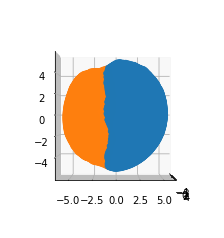

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if dilated == '_smoothed':
    masktype = np.float
else:
    masktype = np.int
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(masktype)
else:
    mask = np.genfromtxt(maskfile, dtype=masktype)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

if dilated == '_smoothed':
    Tfv = (mask > 0.5)
else:
    Tfv = mask.astype(np.bool)
#Tfe = np.all(Tfv[Es], axis=1)
#Tff = np.all(Tfv[Fs], axis=1)
#print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure()#figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

    #eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
    #ax.add_collection(eTf)
    #nTfe = np.logical_not(Tfe)
    #eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
    #ax.add_collection(eTf)

    ax.view_init(azim=0, elev=0)

    ax.set_aspect('equal')
    plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [4]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3097, r0 = 5.2534


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

## 1. Obtain the initial guess

First thing to try is assuming that the deformation only happens on $r$-direction.

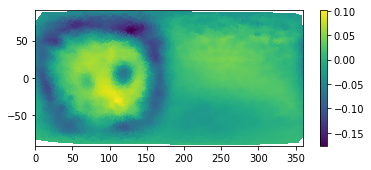

In [5]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

# plot 2d map of the radial displacement
if plot_figure:
    pVlon = Vlon - 180
    pVlon[pVlon < 0] += 360
    plt.figure(figsize=(6,2.5))
    plt.tripcolor(pVlon, Vlat, ur)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.show()

We then smooth the shape using spherical harmonic expansion

In [16]:
lmax_interp = lmax_plot
urcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lmax_interp)
print(chi2)

0.009157847744538856


Evaluation time 0.15843963623046875


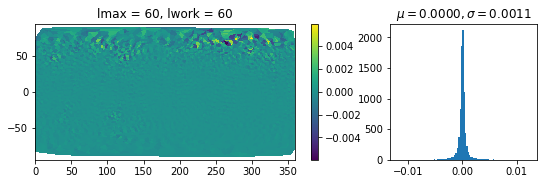

In [50]:
urcoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
tic = time.time()
ur_interp = urcoeff_interp.expand(lat=Vlat, lon=Vlon)
toc = time.time()
print('Evaluation time', toc-tic)

if plot_figure:
    dur = ur_interp-ur
    pVlon = Vlon - 180
    pVlon[pVlon < 0] += 360
    plt.figure(figsize=(9,2.5))
    gridspec.GridSpec(1, 3)
    plt.subplot2grid((1, 3), (0, 0), colspan=2, rowspan=1)
    plt.tripcolor(pVlon, Vlat, dur, shading='gouraud', vmin=-0.05, vmax=0.05)
    plt.colorbar()
    plt.title('lmax = %d, lwork = %d'%(lmax_plot, lmax_plot))
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.subplot2grid((1, 3), (0, 2))
    plt.hist(dur, bins=100); plt.xlim(-0.05, 0.05);
    plt.title(r'$\mu=%.4f, \sigma=%.4f$'%(np.mean(dur), np.std(dur)))
    plt.show()

def damp_coeffs(shcoeffs, lmax=None, lwork=None, plot_spectrum=False):
    lmaxin = shcoeffs.lmax
    if lmax is None:
        lmax = lmaxin
    if lwork is None:
        lwork = int(lmaxin/2)
    lv = l_coeffs(lmaxin); lv_ones = np.ones_like(lv);
    lv_lim = np.minimum(np.maximum(lv, lwork), lmax)
    ldamp = np.sin(np.pi/2*(lmax-lv_lim)/(lmax-lwork))**2
    
    shcoeffs_damp = shcoeffs.copy()
    shcoeffs_damp.coeffs = shcoeffs.to_array()*ldamp
    before = shcoeffs.spectrum(unit='per_lm')
    after = shcoeffs_damp.spectrum(unit='per_lm')
    if plot_spectrum:
        plt.figure()
        plt.semilogy(before); plt.semilogy(after);
        plt.show()
    return shcoeffs_damp

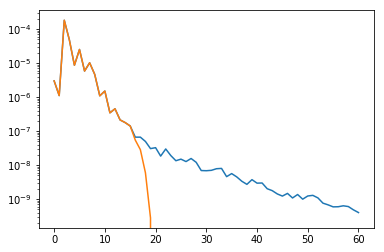

Evaluation time 0.3303s


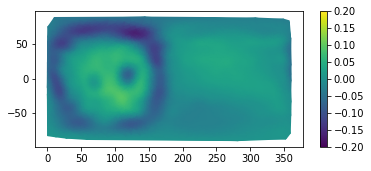

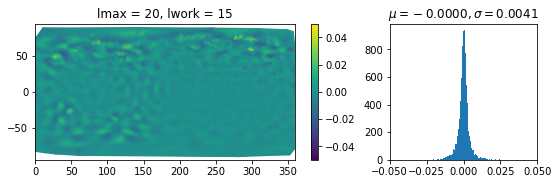

In [68]:
ltry = 20; lworktry = 15;
urcoeff_damp = damp_coeffs(urcoeff_interp, lmax=ltry, lwork=lworktry, plot_spectrum=True)
tic = time.time()
ur_interp = urcoeff_damp.expand(lat=Vlat, lon=Vlon)
toc = time.time()
print('Evaluation time %.4fs'%(toc-tic))

if plot_figure:
    dur = ur_interp-ur
    pVlon = Vlon - 180
    pVlon[pVlon < 0] += 360
    plt.figure(figsize=(6,2.5))
    plt.tripcolor(pVlon, Vlat, ur_interp, shading='gouraud', vmin=-0.2, vmax=0.2)
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(9,2.5))
    gridspec.GridSpec(1, 3)
    plt.subplot2grid((1, 3), (0, 0), colspan=2, rowspan=1)
    plt.tripcolor(pVlon, Vlat, dur, shading='gouraud', vmin=-0.05, vmax=0.05)
    plt.colorbar()
    plt.title('lmax = %d, lwork = %d'%(ltry, lworktry))
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.subplot2grid((1, 3), (0, 2))
    plt.hist(dur, bins=100); plt.xlim(-0.05, 0.05)
    plt.title(r'$\mu=%.4f, \sigma=%.4f$'%(np.mean(dur), np.std(dur)))
    plt.show()

Evaluation time 0.3621s


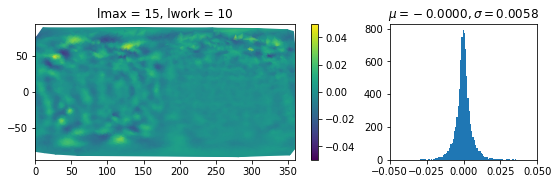

Evaluation time 0.4446s


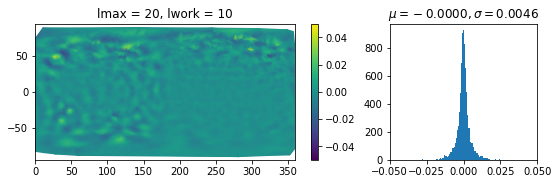

Evaluation time 0.3844s


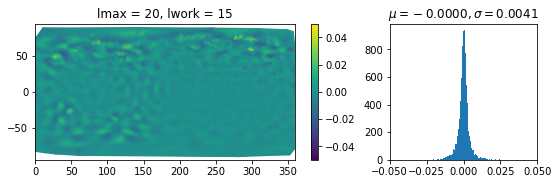

Evaluation time 0.4127s


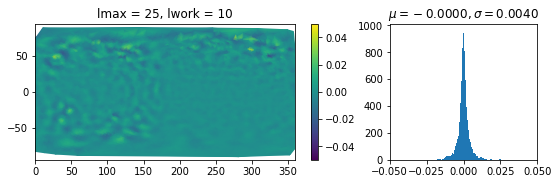

Evaluation time 0.4484s


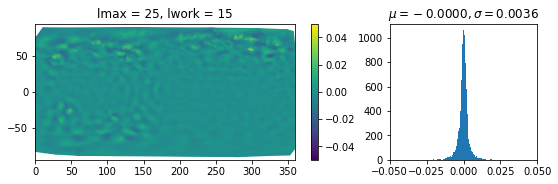

Evaluation time 0.3499s


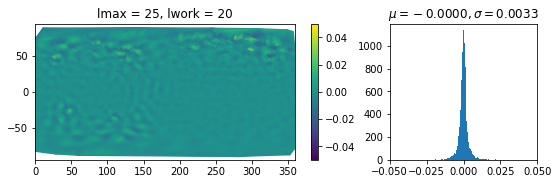

Evaluation time 0.4123s


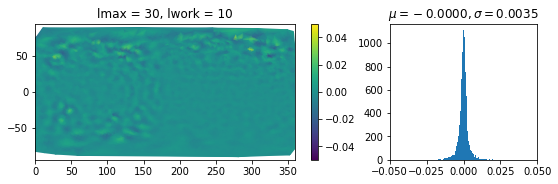

Evaluation time 0.3895s


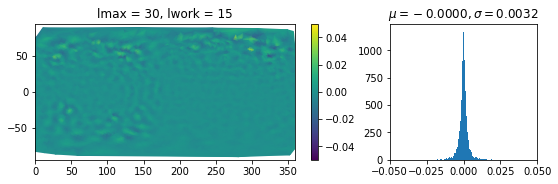

Evaluation time 0.3917s


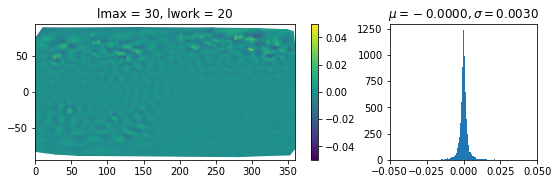

Evaluation time 0.3943s


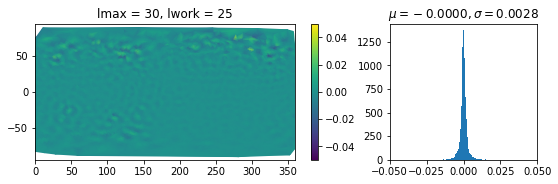

In [73]:
import matplotlib.gridspec as gridspec

# damp the high order coefficients
for ltry in range(15, lJmax+1, 5):
    for lworktry in range(10, ltry, 5):
        urcoeff_damp = damp_coeffs(urcoeff_interp, lmax=ltry, lwork=lworktry)
        tic = time.time()
        ur_interp = urcoeff_damp.expand(lat=Vlat, lon=Vlon)
        toc = time.time()
        print('Evaluation time %.4fs'%(toc-tic))
        Vr_new = ur_interp + r0
        Vp_new = Vp.copy()
        Vp_new[..., 0], Vp_new[..., 1], Vp_new[..., 2] = SphCoord_to_CartCoord(Vr_new, Vthe, Vphi)
        savedata = os.path.join(datadir, shapename+'_Coordinates_Cart_smoothed_lmax%d_lwork%d.csv'%(ltry, lworktry))
        np.savetxt(savedata, Vp_new, fmt='%.5f', delimiter=',')

        if plot_figure:
            dur = ur_interp-ur
            pVlon = Vlon - 180
            pVlon[pVlon < 0] += 360
            plt.figure(figsize=(9,2.5))
            gridspec.GridSpec(1, 3)
            plt.subplot2grid((1, 3), (0, 0), colspan=2, rowspan=1)
            plt.tripcolor(pVlon, Vlat, dur, shading='gouraud', vmin=-0.05, vmax=0.05)
            plt.colorbar()
            plt.title('lmax = %d, lwork = %d'%(ltry, lworktry))
            plt.axis('equal')
            plt.xlim(0, 360)
            plt.ylim(-90, 90)
            plt.subplot2grid((1, 3), (0, 2))
            plt.hist(dur, bins=100); plt.xlim(-0.05, 0.05)
            plt.title(r'$\mu=%.4f, \sigma=%.4f$'%(np.mean(dur), np.std(dur)))
            plt.show()

In [74]:
for i in range(1, 4):
    sph_file = os.path.join(datadir, 'Particle2_Coordinates_Sph_smoothed_%d.csv'%(i+1))
    cart_file = os.path.join(datadir, 'Particle2_Coordinates_Cart_smoothed_%d.csv'%(i+1))
    Vdata = np.genfromtxt(sph_file, delimiter=',')
    print(Vdata[:,0].min(), Vdata[:,0].max(), Vdata[:,1].min(), Vdata[:,1].max())
    Vcart = Vdata.copy()
    Vcart[:, 0], Vcart[:, 1], Vcart[:, 2] = SphCoord_to_CartCoord(Vdata[:, 2], Vdata[:, 1], Vdata[:, 0])
    np.savetxt(cart_file, Vcart, fmt='%.5f', delimiter=',')

-3.1403 3.1415 -1.5649 1.5529
-3.1403 3.1415 -1.5649 1.5529
-3.1403 3.1415 -1.5649 1.5529
